In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import ndimage

from scipy.stats import rice
import time

In [9]:
# --- Assume the setup from the previous step is here ---
# IMAGE_DIR = 'path/to/your/images_folder'
# image_metadata = [...] (the list of 24 dictionaries)
# def load_sar_image(...): ...

# (For completeness, I'm including the setup code again)
# --- TO DO: Update this path ---
IMAGE_DIR = '../images'

# --- Metadata from previous step ---
image_metadata = [
    # Mission 2: Deployment "Sigismund"
    {'mission': 2, 'pass': 1, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 2, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 3, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 4, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 5, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 6, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 3: Deployment "Karl"
    {'mission': 3, 'pass': 1, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_1_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 2, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 3, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 4, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 5, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_5_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 6, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 4: Deployment "Fredrik"
    {'mission': 4, 'pass': 1, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 2, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 3, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 4, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 5, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 6, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 5: Deployment "Adolf-Fredrik"
    {'mission': 5, 'pass': 1, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 2, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 3, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 4, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 5, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 6, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_6_1.a.Fbp.RFcorr.Geo.Magn'},
]

# --- Loading function from previous step ---
def load_sar_image(filename, directory, rows=3000, cols=2000):
    filepath = os.path.join(directory, filename)
    image_data = np.fromfile(filepath, dtype='>f4').reshape((rows, cols))
    return image_data

# --- Main logic for this step ---
if __name__ == '__main__':
    # 1. Select our surveillance image. Let's start with the very first one.
    surveillance_info = image_metadata[0]

    # 2. Find all images that can serve as background references.
    # They must have the same heading but a different deployment name.
    background_stack_info = [
        img_info for img_info in image_metadata
        if img_info['heading'] == surveillance_info['heading']
        and img_info['deployment'] != surveillance_info['deployment']
    ]

    print("--- Surveillance Image ---")
    print(f"Filename: {surveillance_info['filename']}")
    print(f"Heading: {surveillance_info['heading']}°, Deployment: {surveillance_info['deployment']}")
    print("\n--- Background Stack Candidates ---")
    for i, info in enumerate(background_stack_info):
        print(f"{i+1}: {info['filename']} (Heading: {info['heading']}°, Deployment: {info['deployment']})")

    # 3. Load the images into memory.
    try:
        print("\nLoading images...")
        surveillance_image = load_sar_image(surveillance_info['filename'], IMAGE_DIR)
        
        background_images = [
            load_sar_image(info['filename'], IMAGE_DIR) for info in background_stack_info
        ]

        # 4. Stack the background images into a single 3D NumPy array.
        # The shape will be (number_of_images, height, width).
        background_stack = np.stack(background_images, axis=0)

        print("\n--- Data Ready for Processing ---")
        print(f"Surveillance image shape: {surveillance_image.shape}")
        print(f"Background stack shape: {background_stack.shape}")
        
    except (FileNotFoundError, ValueError) as e:
        print(f"\nError: Could not load the image files.")
        print(f"Please ensure your IMAGE_DIR path is correct: '{IMAGE_DIR}'")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

--- Surveillance Image ---
Filename: v02_2_1_1.a.Fbp.RFcorr.Geo.Magn
Heading: 225°, Deployment: Sigismund

--- Background Stack Candidates ---
1: v02_3_1_2.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Karl)
2: v02_3_3_1.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Karl)
3: v02_4_1_1.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Fredrik)
4: v02_4_3_1.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Fredrik)
5: v02_5_1_1.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Adolf-Fredrik)
6: v02_5_3_1.a.Fbp.RFcorr.Geo.Magn (Heading: 225°, Deployment: Adolf-Fredrik)

Loading images...

--- Data Ready for Processing ---
Surveillance image shape: (3000, 2000)
Background stack shape: (6, 3000, 2000)


--- Background Model Complete ---
Shape of the mean map: (3000, 2000)
Shape of the std deviation map: (3000, 2000)


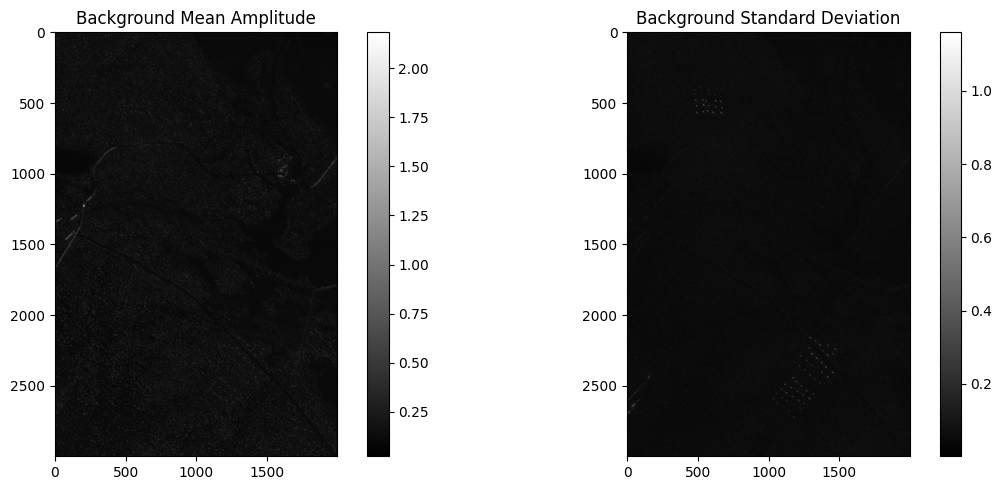

In [10]:
# This code assumes you have the 'background_stack' variable 
# from the previous step, with the shape (6, 3000, 2000).

# Calculate the mean for each pixel across the 6 background images.
# The 'axis=0' tells NumPy to compute the mean along the first dimension (the 6 images).
# The result will be a 2D array of shape (3000, 2000).
mean_map = np.mean(background_stack, axis=0)

# Similarly, calculate the standard deviation for each pixel.
std_map = np.std(background_stack, axis=0)

print("--- Background Model Complete ---")
print(f"Shape of the mean map: {mean_map.shape}")
print(f"Shape of the std deviation map: {std_map.shape}")

# Let's visualize our new statistical maps to see what they look like.
plt.figure(figsize=(12, 5))

# Plotting the mean map
plt.subplot(1, 2, 1)
plt.imshow(mean_map, cmap='gray')
plt.title('Background Mean Amplitude')
plt.colorbar()

# Plotting the standard deviation map
plt.subplot(1, 2, 2)
plt.imshow(std_map, cmap='gray')
plt.title('Background Standard Deviation')
plt.colorbar()

plt.tight_layout()
plt.show()

In [11]:
# # This code assumes you have the 'surveillance_image', 'mean_map', and 'std_map'
# # variables from the previous steps.

# # To avoid division by zero for pixels with no variation, add a small constant.
# epsilon = 1e-8

# # Calculate the change map by finding the normalized difference.
# # This is conceptually similar to a Z-score for each pixel.
# change_map = (surveillance_image - mean_map) / (std_map + epsilon)

# # Set a detection threshold. A higher value means fewer, but more confident, detections.
# # The baseline algorithm in one of the papers uses a threshold of 6[cite: 418]. Let's start with that.
# threshold = 6.0

# # Apply the threshold to the change map to get a binary image.
# # Pixels with a value > threshold are marked as 1 (detection), others are 0.
# detection_map = change_map > threshold

# print("--- Change Detection Complete ---")
# print(f"Number of detected pixels: {np.sum(detection_map)}")


# # --- Visualize the results ---
# plt.figure(figsize=(18, 6))

# # 1. Original Surveillance Image
# plt.subplot(1, 3, 1)
# plt.imshow(np.log(surveillance_image + epsilon), cmap='gray')
# plt.title('Surveillance Image (Log Scale)')
# plt.xlabel('Range (pixels)')
# plt.ylabel('Azimuth (pixels)')

# # 2. The calculated Change Map
# plt.subplot(1, 3, 2)
# plt.imshow(change_map, cmap='jet', vmin=0, vmax=threshold + 4) # Use 'jet' colormap
# plt.title('Change Map (Normalized Difference)')
# plt.xlabel('Range (pixels)')

# # 3. The final Binary Detections
# plt.subplot(1, 3, 3)
# plt.imshow(detection_map, cmap='gray')
# plt.title(f'Binary Detections (Threshold = {threshold})')
# plt.xlabel('Range (pixels)')

# plt.tight_layout()
# plt.show()

In [12]:
# --- Assume variables from previous steps are available ---
# surveillance_image: The (3000, 2000) surveillance image.
# background_stack: The (6, 3000, 2000) background stack.
# epsilon = 1e-8

# --- Define output filenames for the parameter maps ---
# We will save our work here to avoid re-calculating later.
PARAM_DIR = 'parameter_maps'
if not os.path.exists(PARAM_DIR):
    os.makedirs(PARAM_DIR)

B_MAP_FILE = os.path.join(PARAM_DIR, 'b_map.npy')
LOC_MAP_FILE = os.path.join(PARAM_DIR, 'loc_map.npy')
SCALE_MAP_FILE = os.path.join(PARAM_DIR, 'scale_map.npy')

# --- Step 4 (Corrected): Model Background with Rician MLE for the Full Image ---

# Check if the parameter maps have already been calculated and saved
if os.path.exists(B_MAP_FILE):
    print("Loading pre-calculated Rician parameter maps from disk...")
    b_map = np.load(B_MAP_FILE)
    loc_map = np.load(LOC_MAP_FILE)
    scale_map = np.load(SCALE_MAP_FILE)
else:
    print("Beginning Rician MLE fit for the entire 3000x2000 image.")
    print("This will take a very long time. Please be patient.")
    start_time = time.time()
    
    rows, cols = surveillance_image.shape
    
    # Create empty maps to store the estimated Rician parameters
    b_map = np.zeros_like(surveillance_image)
    loc_map = np.zeros_like(surveillance_image)
    scale_map = np.zeros_like(surveillance_image)

    # Iterate over every single pixel in the image
    for r in range(rows):
        for c in range(cols):
            pixel_data = background_stack[:, r, c]
            b, loc, scale = rice.fit(pixel_data, floc=0)
            b_map[r, c] = b
            loc_map[r, c] = loc
            scale_map[r, c] = scale
        
        # Print progress update every 100 rows
        if (r + 1) % 100 == 0:
            elapsed = time.time() - start_time
            print(f"Processed row {r+1}/{rows}... Time elapsed: {elapsed/60:.2f} minutes.")
            
    end_time = time.time()
    print(f"Finished fitting in {end_time - start_time:.2f} seconds.")
    
    # Save the results to prevent having to do this again!
    print(f"Saving parameter maps to '{PARAM_DIR}' directory...")
    np.save(B_MAP_FILE, b_map)
    np.save(LOC_MAP_FILE, loc_map)
    np.save(SCALE_MAP_FILE, scale_map)

# --- Step 5 (Corrected): Apply Rician CDF Detection Criterion ---
print("Applying Rician CDF change detection on the full image...")

p_fa = 0.001
detection_threshold = 1 - p_fa
full_detection_map = np.zeros_like(surveillance_image, dtype=bool)

# This part is much faster as it's just calculations, not fitting.
# We can use NumPy's vectorized operations instead of a loop.
cdf_values = rice.cdf(surveillance_image, b_map, loc=loc_map, scale=(scale_map + epsilon))
full_detection_map = cdf_values >= detection_threshold

print("Detection complete.")

# --- Visualize the final, correct detection map ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log(surveillance_image + epsilon), cmap='gray')
plt.title('Full Surveillance Image (Log Scale)')

plt.subplot(1, 2, 2)
plt.imshow(full_detection_map, cmap='gray')
plt.title(f'Final Detections (PFA = {p_fa})')
plt.show()

Beginning Rician MLE fit for the entire 3000x2000 image.
This will take a very long time. Please be patient.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9322: RuntimeWarning: overflow encountered in multiply
  return x * np.exp(-(x-b)*(x-b)/2.0) * sc.i0e(x*b)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2420: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9322: RuntimeWarning: invalid value encountered in multiply
  return x * np.exp(-(x-b)*(x-b)/2.0) * sc.i0e(x*b)


Processed row 100/3000... Time elapsed: 7.55 minutes.
Processed row 200/3000... Time elapsed: 15.13 minutes.
Processed row 300/3000... Time elapsed: 22.65 minutes.
Processed row 400/3000... Time elapsed: 30.19 minutes.
Processed row 500/3000... Time elapsed: 37.71 minutes.
Processed row 600/3000... Time elapsed: 45.25 minutes.
Processed row 700/3000... Time elapsed: 66.61 minutes.
Processed row 800/3000... Time elapsed: 74.31 minutes.
Processed row 900/3000... Time elapsed: 81.87 minutes.
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zp/zxk2y7wn4dxfhmh_5sby08bc0000gn/T/ipykernel_51347/2807365850.py", line 40, in <module>
    b, loc, scale = rice.fit(pixel_data, floc=0)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 2740, in fit
    vals = optimizer(func, x0, args=(data,), disp=0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py", line 669, in fmin
    res = _minimize_neldermead(func, x0, args, callback=callback, **opts)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frame

--- Post-Processing Complete ---
Pixels detected before processing: 21956
Pixels detected after processing:  2292


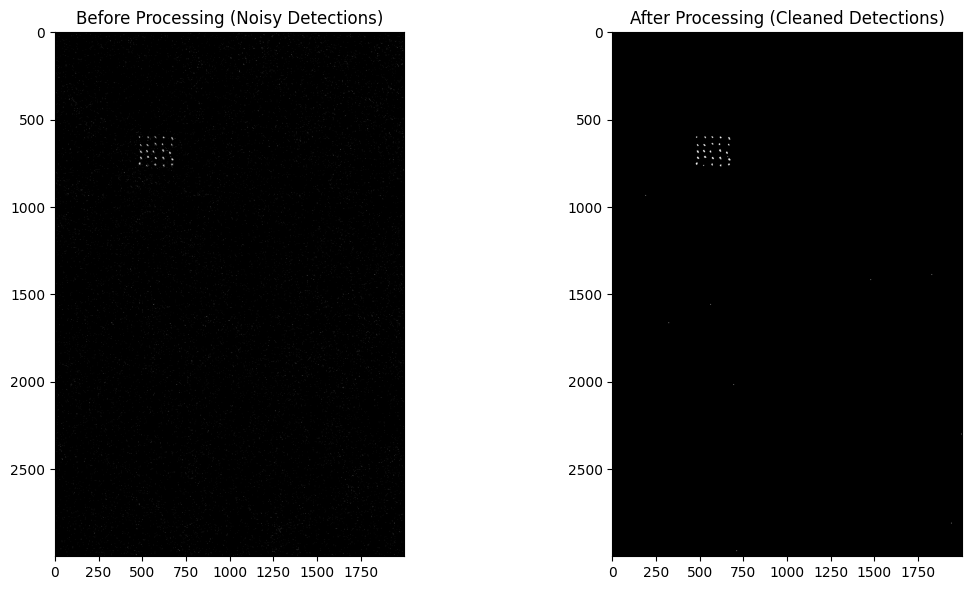

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# This code assumes you have the 'detection_map' variable from the previous step.
# For demonstration, let's create a dummy one if it doesn't exist.
if 'detection_map' not in locals():
    # Create a sample noisy map for standalone execution
    np.random.seed(0)
    detection_map = np.zeros((100, 100), dtype=bool)
    detection_map[20:40, 20:40] = True # A target region
    noise = np.random.rand(100, 100) > 0.99
    detection_map = np.logical_or(detection_map, noise)


# 1. Apply one erosion operation to remove noise.
eroded_map = ndimage.binary_erosion(detection_map)

# 2. Apply two dilation operations to merge target pixels.
processed_map = ndimage.binary_dilation(eroded_map)
processed_map = ndimage.binary_dilation(processed_map)

print("--- Post-Processing Complete ---")
print(f"Pixels detected before processing: {np.sum(detection_map)}")
print(f"Pixels detected after processing:  {np.sum(processed_map)}")


# --- Visualize the results for comparison ---
plt.figure(figsize=(12, 6))

# Before Processing
plt.subplot(1, 2, 1)
plt.imshow(detection_map, cmap='gray')
plt.title('Before Processing (Noisy Detections)')

# After Processing
plt.subplot(1, 2, 2)
plt.imshow(processed_map, cmap='gray')
plt.title('After Processing (Cleaned Detections)')

plt.tight_layout()
plt.show()

In [ ]:
# --- Assume variables from previous steps are available ---
# processed_map: The (3000, 2000) cleaned-up binary detection map.
# surveillance_info: The dictionary for our surveillance image.

# --- TO DO: Update this path ---
# The path to the folder containing the target list .txt files.
TARGET_DIR = '../target_lists'

# --- 1. Find the center of each detected object ---
# 'label' finds connected white regions and gives each a unique number.
# 'num_objects' will be the total count of separate detections.
labeled_map, num_objects = ndimage.label(processed_map)
# Calculate the center of mass (centroid) for each labeled object.
# The result is a list of (row, col) tuples.
detected_centers = ndimage.center_of_mass(processed_map, labeled_map, range(1, num_objects + 1))

print(f"Found {num_objects} distinct object(s) in the processed map.")

# --- 2. Load the ground truth data ---
target_filename = surveillance_info['deployment'] + ".Targets.txt"
target_filepath = os.path.join(TARGET_DIR, target_filename)

try:
    # Each row is [Northing, Easting, Type]
    ground_truth_geo = np.loadtxt(target_filepath, usecols=(0, 1))
    num_true_targets = len(ground_truth_geo)
    print(f"Loaded {num_true_targets} ground truth targets from {target_filename}")

    # --- 3. Convert geographic coords to pixel coords ---
    # These constants are from the data_description.pdf [cite: 22, 27, 29, 31]
    Nmax, Nmin = 7370488, 7367489
    Emax, Emin = 1655165, 1653166

    ground_truth_pixels = []
    for north, east in ground_truth_geo:
        row = round(Nmax - north) # Formula from docs [cite: 53]
        col = round(east - Emin) # Formula from docs [cite: 54]
        ground_truth_pixels.append((row, col))
    
    # --- 4. Match detections to ground truth targets ---
    match_radius = 10.0 # 10 pixels (10 meters) 
    true_positives = 0
    
    # Keep track of which detections have been matched to a target
    unmatched_detections = list(detected_centers)
    
    for true_target_pos in ground_truth_pixels:
        found_match = False
        for i, detected_pos in enumerate(unmatched_detections):
            # Calculate Euclidean distance
            distance = np.sqrt((true_target_pos[0] - detected_pos[0])**2 + 
                               (true_target_pos[1] - detected_pos[1])**2)
            
            if distance <= match_radius:
                true_positives += 1
                unmatched_detections.pop(i) # Remove detection so it can't be matched again
                found_match = True
                break # Move to the next true target
    
    false_positives = len(unmatched_detections) # Any leftover detections are false alarms
    
    # --- 5. Calculate final performance metrics ---
    image_area_km2 = 6.0 # The images are 2km x 3km [cite: 165]
    
    # Probability of Detection (Pd) [cite: 466]
    pd = true_positives / num_true_targets
    
    # False Alarm Rate (FAR) [cite: 467]
    far = false_positives / image_area_km2
    
    print("\n--- Performance Results ---")
    print(f"True Positives (Targets Found): {true_positives} / {num_true_targets}")
    print(f"False Positives (False Alarms): {false_positives}")
    print(f"Probability of Detection (Pd): {pd:.2%}")
    print(f"False Alarm Rate (FAR): {far:.2f} alarms/km²")

except FileNotFoundError:
    print(f"Error: Could not find the target file at '{target_filepath}'")
    print("Please check that your TARGET_DIR path is correct.")

Found 38 distinct object(s) in the processed map.
Loaded 25 ground truth targets from Sigismund.Targets.txt

--- Performance Results ---
True Positives (Targets Found): 25 / 25
False Positives (False Alarms): 13
Probability of Detection (Pd): 100.00%
False Alarm Rate (FAR): 2.17 alarms/km²
